In [1]:
from BSTools_pennylane import *
from matplotlib import pyplot as plt
from matplotlib import cm

In [11]:
# PDE parameters
sigma = 0.5
r = 0.3
Smax = 135
K = 50
T = 1

# Simulation parameters
n = 6 # Number of qubits
N = 2**n


instance = BS(r,K,Smax)

### State preparation

##### The state preparation can be done approximately, with the parameter $k$

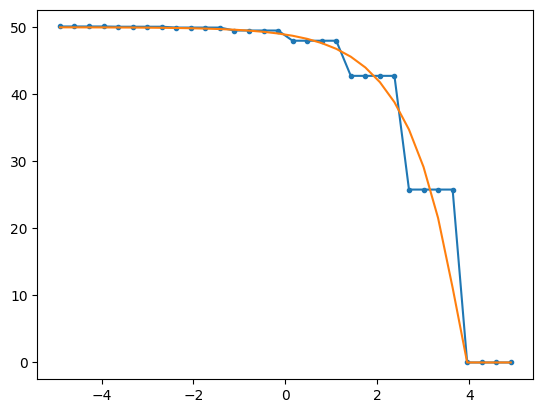

In [14]:
V = instance.solve("QC",n,sigma,T=0, order=False, k=4)
exact = instance.solve("exactp",n,sigma,T=0)
x = instance.x
plt.plot(x,V,'.-')
plt.plot(x,exact)
plt.show()

In [4]:
# c = instance.solve("QC",n,sigma,T, order=False, M=[N//4,N//4], k=8)
c = instance.solve("QC",n,sigma,T, order=True)
ex = instance.solve("exact",n,sigma,T)
exp = instance.solve("exactp",n,sigma,T, NFourier=50)


def L2(a,b):
    return np.linalg.norm(a-b)/np.linalg.norm(b)

print(L2(c,ex))
print(L2(c,exp))

0.0028509869632668437
0.0017703767621951808


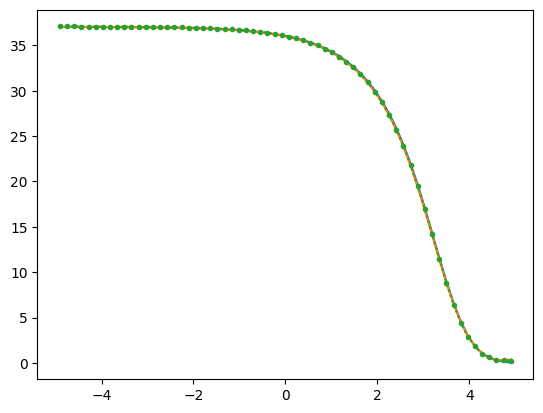

In [6]:
x = instance.x
plt.plot(x,ex)
plt.plot(x,exp)
plt.plot(x,c,'.:')
plt.show()

In [7]:
def Ngates(circuit, args):
    dict_op = qml.specs(circuit)(*args)["resources"].gate_types
    count = 0
    for op,num in dict_op.items():
        if 'C' in op:
            count+=num
    return count

In [8]:

cnode = qml.QNode(instance.Circuit, instance.dev)
print(Ngates(cnode,[instance.get_coef_H(T), instance.get_coef_A(T), n, N//2,N//2, False]))

c_compile = qml.compile(instance.Circuit)
c_compile_node = qml.QNode(c_compile, instance.dev)
print(Ngates(c_compile_node,[instance.get_coef_H(T), instance.get_coef_A(T), n, N//2,N//2, False]))


cnode = qml.QNode(instance.Circuit, instance.dev)
print(Ngates(cnode,[instance.get_coef_H(T), instance.get_coef_A(T), n, N//2,N//2, True]))

c_compile = qml.compile(instance.Circuit)
c_compile_node = qml.QNode(c_compile, instance.dev)
print(Ngates(c_compile_node,[instance.get_coef_H(T), instance.get_coef_A(T), n, N//2,N//2, True]))

470
512
288
320


In [9]:
1-178/246

0.2764227642276422

In [10]:
print(qml.draw(c_compile_node)(instance.get_coef_H(T), instance.get_coef_A(T), n, N//2,N//2, False))

0: ──RY(1.42)─────────────────────────────────────────────────────────────────────────────────────
1: ──RY(1.47)─────────────────────────────────────────────────────────────────────────────────────
2: ──RY(1.57)─────────────────────────────────────────────────────────────────────────────────────
3: ──RY(1.57)─────────────────────────────────────────────────────────╭X──RY(0.34)─╭X─╭X──RY(0.39)
4: ──RY(1.57)─────────────────────────╭X──RY(0.38)─╭X─╭X──RY(0.39)─╭X─╰●───────────│──╰●──────────
5: ──RY(1.57)─╭X──────────RY(0.35)─╭X─╰●───────────│──╰●───────────│───────────────╰●─────────────
6: ──RY(1.57)─╰●───────────────────╰●──────────────╰●──────────────╰●─────────────────────────────
7: ──Z─────────Rϕ(-1.57)──H───────────────────────────────────────────────────────────────────────
8: ───────────────────────────────────────────────────────────────────────────────────────────────

────────────────────────────────────────────────────────────────────────────────────────────────────
───────